# Sprint 16: Advanced machine learning

#### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from statistics import mean

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

I will analyze dataset about natural gas consumption in Catalonia during the period 2013 - 2020.
 - dataset opendata: https://analisi.transparenciacatalunya.cat/Energia/Consum-de-gas-natural-canalitzat-per-municipis-i-s/qvqg-zag8
 - price of natural gas for domestic use: https://es.statista.com/estadisticas/504539/precios-semestrales-al-consumidor-de-gas-natural-en-espana/
 - PIB Catalunya: https://www.idescat.cat/pub/?id=aec&n=354&lang=es
 - Total consumption of energies in Catalunya: https://www.idescat.cat/pub/?id=aec&n=501&lang=es

In [2]:
df = pd.read_csv("gas_natural.csv")
df.head(3)

,ANY,PROVINCIA,COMARCA,CDMUN,MUNICIPI,SECTOR,Consum [kWh PCS],Observacions
0,2013,GIRONA,GIRONES,17002,AIGUAVIVA,INDUSTRIAL,19570323.0,NaN
1,2013,GIRONA,GIRONES,17002,AIGUAVIVA,TERCIARI,NaN,Dada subjecta a secret estadístic.
2,2013,GIRONA,GIRONES,17002,AIGUAVIVA,USOS DOMESTICS,1231527.0,NaN


In [3]:
df.describe()

,ANY,CDMUN,Consum [kWh PCS]
count,7622.000000,7622.000000,6.006000e+03
mean,2016.580294,17104.379166,5.212483e+07
std,2.280212,12184.310737,3.246794e+08
min,2013.000000,8001.000000,6.900000e+01
25%,2015.000000,8147.000000,2.069246e+06
50%,2017.000000,8292.000000,7.128224e+06
75%,2019.000000,25022.500000,2.453861e+07
max,2020.000000,43907.000000,8.641686e+09


Features to create machine learning model:
- Year
- Minicipal code
- Sector
- Consumption in kWh

In [4]:
df.columns

Index(['ANY', 'PROVINCIA', 'COMARCA', 'CDMUN', 'MUNICIPI', 'SECTOR',
       'Consum [kWh PCS]', 'Observacions'],
      dtype='object')

In [5]:
df_gas = df[['ANY','CDMUN','SECTOR','Consum [kWh PCS]']]    

In [6]:
df_gas = df_gas.rename({'ANY': 'Year', 'CDMUN': 'Municipal_Code',
                        'SECTOR': 'Sector', 'Consum [kWh PCS]': 'Consumption'}, axis='columns')
df_gas.head(2)

,Year,Municipal_Code,Sector,Consumption
0,2013,17002,INDUSTRIAL,19570323.0
1,2013,17002,TERCIARI,NaN


In [7]:
#select only domestic sector
df_dom = df_gas.loc[df_gas['Sector'] == 'USOS DOMESTICS']
df_dom.head(2)

,Year,Municipal_Code,Sector,Consumption
2,2013,17002,USOS DOMESTICS,1231527.0
5,2014,17002,USOS DOMESTICS,1031488.0


In [8]:
#price of natural gas by year - information from another dataset
conditions1 = [
    (df_dom['Year'] == 2013),
    (df_dom['Year'] == 2014),
    (df_dom['Year'] == 2015),
    (df_dom['Year'] == 2016),
    (df_dom['Year'] == 2017),
    (df_dom['Year'] == 2018),
    (df_dom['Year'] == 2019),
    (df_dom['Year'] == 2020)]

values = [0.065, 0.070, 0.070, 0.060, 0.060, 0.060, 0.065, 0.060]

df_dom['Price'] = np.select(conditions1, values)

In [9]:
#inflation in Catalonia by year - information from another dataset 
conditions2 = [
    (df_dom['Year'] == 2013),
    (df_dom['Year'] == 2014),
    (df_dom['Year'] == 2015),
    (df_dom['Year'] == 2016),
    (df_dom['Year'] == 2017),
    (df_dom['Year'] == 2018),
    (df_dom['Year'] == 2019),
    (df_dom['Year'] == 2020)]

values = [1.7, 0.1, -0.2, 0.1, 2.2, 1.8, 0.9, -0.4]

df_dom['Inflation'] = np.select(conditions2, values)

In [10]:
#total energy consumption in Catalonia by year - information from another dataset 
#missing value for 2020 - let's calculate the mean value
def Average(values):
    return mean(values)

values = [23204, 23254, 24403, 24556, 25298, 24867, 25371]
average = Average(values)
round(average, 0)

24422.0

In [11]:
#total energy consumption in Catalonia by year, thousands of toe - information from another dataset 
conditions3 = [
    (df_dom['Year'] == 2013),
    (df_dom['Year'] == 2014),
    (df_dom['Year'] == 2015),
    (df_dom['Year'] == 2016),
    (df_dom['Year'] == 2017),
    (df_dom['Year'] == 2018),
    (df_dom['Year'] == 2019),
    (df_dom['Year'] == 2020)]

values = [23204, 23254, 24403, 24556, 25298, 24867, 25371, 24422]

df_dom['Total_energy_consum'] = np.select(conditions3, values)

In [12]:
#total PIB in Catalonia, Millons of euros - information from another dataset 
conditions3 = [
    (df_dom['Year'] == 2013),
    (df_dom['Year'] == 2014),
    (df_dom['Year'] == 2015),
    (df_dom['Year'] == 2016),
    (df_dom['Year'] == 2017),
    (df_dom['Year'] == 2018),
    (df_dom['Year'] == 2019),
    (df_dom['Year'] == 2020)]

values = [201531, 204896, 213746, 222514, 232187, 241670, 249900, 224125]

df_dom['Total_energy_consum'] = np.select(conditions3, values)

In [13]:
df_dom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2934 entries, 2 to 7621
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 2934 non-null   int64  
 1   Municipal_Code       2934 non-null   int64  
 2   Sector               2934 non-null   object 
 3   Consumption          2929 non-null   float64
 4   Price                2934 non-null   float64
 5   Inflation            2934 non-null   float64
 6   Total_energy_consum  2934 non-null   int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 183.4+ KB


In [14]:
df_final = df_dom.copy()
df_final.head(5)

,Year,Municipal_Code,Sector,Consumption,Price,Inflation,Total_energy_consum
2,2013,17002,USOS DOMESTICS,1231527.0,0.065,1.7,201531
5,2014,17002,USOS DOMESTICS,1031488.0,0.070,0.1,204896
8,2015,17002,USOS DOMESTICS,1162227.0,0.070,-0.2,213746
11,2016,17002,USOS DOMESTICS,1108508.0,0.060,0.1,222514
14,2017,17002,USOS DOMESTICS,1184582.0,0.060,2.2,232187


In [15]:
df_final.isna().sum()

Year                   0
Municipal_Code         0
Sector                 0
Consumption            5
Price                  0
Inflation              0
Total_energy_consum    0
dtype: int64

In [16]:
#calculating mean value for missing data
def myfunc(x):
    df_final[x]=df_final[x].fillna(df_final[x].mean())

mylist = ['Consumption']
for x in mylist:
    myfunc(x)

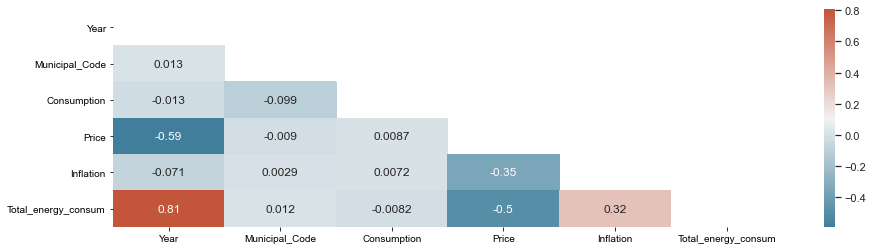

In [17]:
#correlation matrix
fig,ax = plt.subplots(figsize=(15,4))
corr = df_final.corr()
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)

matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix, cmap=cmap)
plt.show()

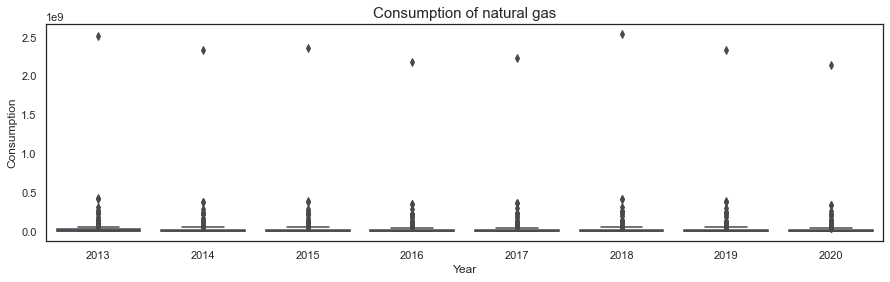

In [18]:
#consumption by years
fig,ax = plt.subplots(figsize=(15,4))
sns.set_theme(style="whitegrid")

sns.boxplot(x ='Year',y='Consumption',data=df_final)
plt.xlabel("Year",fontsize=12)
plt.ylabel("Consumption",fontsize=12)
plt.title("Consumption of natural gas",fontsize=15)

plt.show()

In [19]:
#dealing with outliers - in case of this dataset its Barcelona region - very high consumption
df_barcelona = df_final.loc[df_final['Municipal_Code'] == 8019]
df_barcelona

,Year,Municipal_Code,Sector,Consumption,Price,Inflation,Total_energy_consum
3833,2013,8019,USOS DOMESTICS,2.516416e+09,0.065,1.7,201531
3837,2014,8019,USOS DOMESTICS,2.332439e+09,0.070,0.1,204896
3841,2015,8019,USOS DOMESTICS,2.362253e+09,0.070,-0.2,213746
3845,2016,8019,USOS DOMESTICS,2.174079e+09,0.060,0.1,222514
3849,2017,8019,USOS DOMESTICS,2.232814e+09,0.060,2.2,232187
3853,2018,8019,USOS DOMESTICS,2.544151e+09,0.060,1.8,241670
3857,2019,8019,USOS DOMESTICS,2.329508e+09,0.065,0.9,249900
3861,2020,8019,USOS DOMESTICS,2.145951e+09,0.060,-0.4,224125


In [20]:
#locating only Barcelona rows
df3 = df_final[ df_final['Municipal_Code'] == 8019]
#dropping these rows
df_final = df_final.drop(df3.index, axis=0)

In [21]:
df_final.head(5)

,Year,Municipal_Code,Sector,Consumption,Price,Inflation,Total_energy_consum
2,2013,17002,USOS DOMESTICS,1231527.0,0.065,1.7,201531
5,2014,17002,USOS DOMESTICS,1031488.0,0.070,0.1,204896
8,2015,17002,USOS DOMESTICS,1162227.0,0.070,-0.2,213746
11,2016,17002,USOS DOMESTICS,1108508.0,0.060,0.1,222514
14,2017,17002,USOS DOMESTICS,1184582.0,0.060,2.2,232187


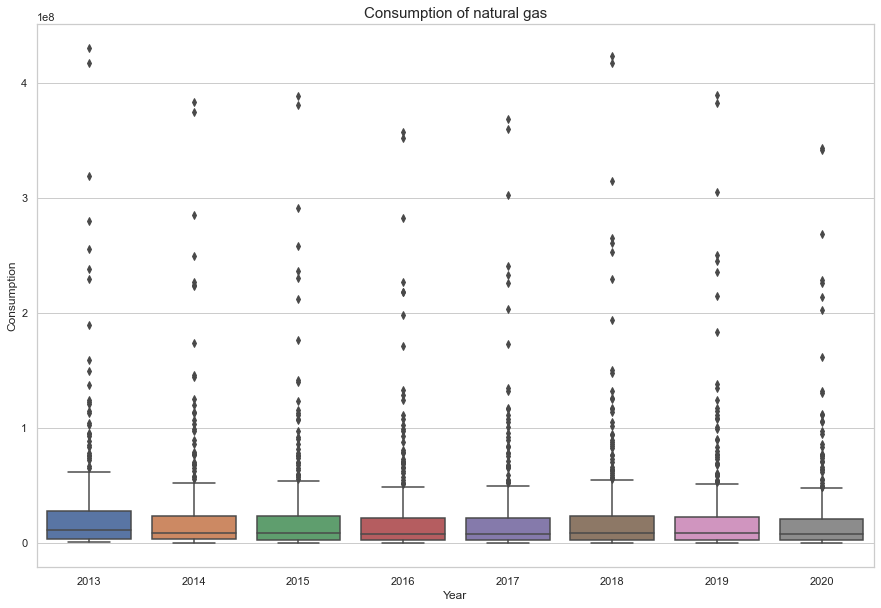

In [58]:
#consumption by years
fig,ax = plt.subplots(figsize=(15,10))
sns.set_theme(style="whitegrid")

sns.boxplot(x = 'Year',y='Consumption',data=df_final)
plt.xlabel("Year",fontsize=12)
plt.ylabel("Consumption",fontsize=12)
plt.title("Consumption of natural gas",fontsize=15)

plt.savefig('boxplot.pdf')
plt.show()

## Level 1

### Exercise 1

#### Aplication of Pipeline and GridSearch with Random Forest

In [23]:
#train and test
X = df_final.drop(['Consumption','Sector'],axis=1)
y = df_final['Consumption']
#train 70%, test 30%, test_size is the percentage and random_state is for initilizing random number generator
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
#steps: what will pipleline do step by step
steps = [('scaler', StandardScaler()), ('RF', RandomForestRegressor())]
#pipline instance
pipeline = Pipeline(steps)

In [25]:
#param: what to try during the cross validation
parameteres = {'RF__n_estimators':[10,20,30,40,50,100], 'RF__max_depth':[1,5,10]}
#grid: cross validation model
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('RF', RandomForestRegressor())]),
             param_grid={'RF__max_depth': [1, 5, 10],
                         'RF__n_estimators': [10, 20, 30, 40, 50, 100]})

In [26]:
print("score = %3.2f" %(grid.score(X_test,y_test)))
print(grid.best_params_)

score = 0.92
{'RF__max_depth': 10, 'RF__n_estimators': 30}


This result can vary with different train and test samples.

In [27]:
#creating the best model
model = Pipeline(steps=[('scaler', StandardScaler()),
                       ('RF', RandomForestRegressor(max_depth=10,n_estimators=40))])
model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('RF', RandomForestRegressor(max_depth=10, n_estimators=40))])

In [28]:
x = model.predict(X_test)
x[:10]

array([ 7367077.19924885,  3299116.70964722,  2314328.16572548,
       24846872.3052551 ,  4856985.723141  ,  8087692.16194242,
       21832573.75358883,  4409731.96494216, 20395268.4051313 ,
       36159676.74066021])

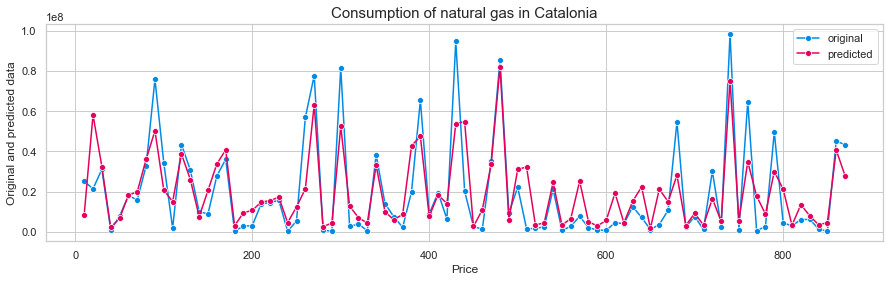

In [29]:
#compare values from test and predict
y1 = y_test.reset_index(drop=True)
y2 = pd.Series(model.predict(X_test))

#for simple visualization let's take sistematic sample
step_num = 10
def randomNum():
    num = np.random.randint(1, 50)
    return num
num = randomNum()

simple_df1 = y1[num:len(y1):step_num]
simple_df2 = y2[num:len(y2):step_num]

plt.figure(figsize =(15, 4))

sns.lineplot(data=simple_df1, color='#008ae6',label='original', marker='o')
sns.lineplot(data=simple_df2, color='#e6005c',label='predicted', marker='o')
plt.title("Consumption of natural gas in Catalonia",fontsize=15)
plt.xlabel("Price",fontsize=12)
plt.ylabel("Original and predicted data",fontsize=12)

plt.show()

### Exercise 2

#### Frequency of words in english text

In [30]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
nltk.download('punkt', quiet=True)

True

In [31]:
text = open("words.txt").read()

In [32]:
tokenized_text=sent_tokenize(text)
print(tokenized_text)

["Natural gas prices have surged in Europe as countries exit COVID-19 lockdown, fuelling a crisis that is likely to impact consumers' bills this winter.", 'The cost is now six times higher than what it was last year in Europe and is continuing to increase, with the crisis unlikely to abate before the spring.', 'Governments are scrambling to issue subsidies and cut taxes in an effort to protect consumers.', "Here are five charts to help you visualise what's going on.", 'The price of natural gas is six times higher than last year and about four times higher than this past spring.', "It's due to an increase in demand globally as countries restart their economies and come out of lockdown.", 'A longer winter last year and competition from East Asian countries for gas has influenced rising prices.', 'There are also problems on the supply end, with delayed maintenance and less investment causing problems.', "These gas prices are in turn determining the price in electricity markets, as over a 

In [33]:
tokenized_word=word_tokenize(text)
print(tokenized_text)

["Natural gas prices have surged in Europe as countries exit COVID-19 lockdown, fuelling a crisis that is likely to impact consumers' bills this winter.", 'The cost is now six times higher than what it was last year in Europe and is continuing to increase, with the crisis unlikely to abate before the spring.', 'Governments are scrambling to issue subsidies and cut taxes in an effort to protect consumers.', "Here are five charts to help you visualise what's going on.", 'The price of natural gas is six times higher than last year and about four times higher than this past spring.', "It's due to an increase in demand globally as countries restart their economies and come out of lockdown.", 'A longer winter last year and competition from East Asian countries for gas has influenced rising prices.', 'There are also problems on the supply end, with delayed maintenance and less investment causing problems.', "These gas prices are in turn determining the price in electricity markets, as over a 

In [34]:
fdist = FreqDist(tokenized_word)
print(fdist)

<FreqDist with 110 samples and 191 outcomes>


In [35]:
fdist.most_common(2)

[('.', 9), ('to', 7)]

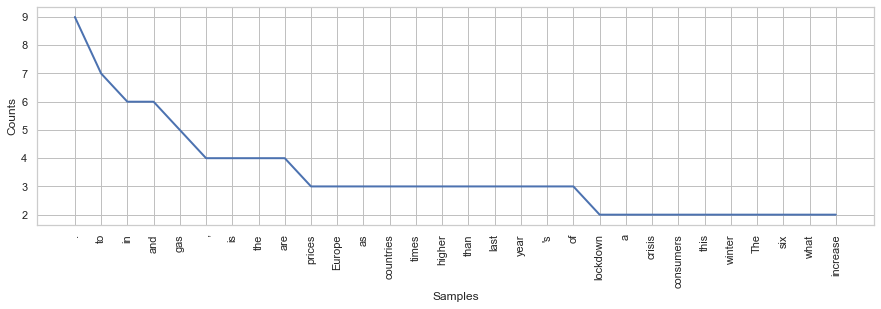

In [36]:
plt.figure(figsize =(15, 4))
fdist.plot(30,cumulative=False)
plt.show()

## Level 2

### Exercise 3

#### Stopwords, stemming

In [37]:
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
stop_words=set(stopwords.words("english"))
print(stop_words)

{'which', 'all', 'y', 'you', 'with', 'your', 'him', 'if', 'during', 'ain', 'any', "doesn't", 'll', "wasn't", 'and', 'same', 'were', 'but', 'here', 'themselves', "couldn't", "that'll", 'is', "mightn't", "should've", 'ourselves', 'a', 'how', 'm', 'his', "you'd", 'hasn', 'up', 'd', 'own', 'my', 'herself', 'are', 'be', 'me', 'by', "hasn't", 'before', 'what', 'myself', 'these', 'about', 'while', 'after', 'aren', 'an', 'didn', 'of', 'yourself', 'needn', 'shan', "shan't", 'below', 'no', 'above', 'am', 'who', 'both', 'will', 'because', 'why', 'himself', 'should', 'off', 're', 'into', "you're", 'other', 'shouldn', 'for', 'or', 'doing', "don't", 'has', 'until', 'most', 'such', 'more', 'further', 'so', 's', 'to', 'from', 'he', "haven't", 'some', 'we', 'its', 'don', 'doesn', 'ma', "mustn't", 'couldn', 'out', "wouldn't", 'not', 'wasn', 'too', 'their', 'have', 'against', 'at', 'those', "hadn't", "needn't", 'few', 'on', 'now', 'ours', "didn't", "you've", 'down', 'hers', "aren't", 'did', 'whom', 'ther

In [38]:
#removing stopwords
filtered_sent=[]
for w in tokenized_word:
    if w not in stop_words:
        filtered_sent.append(w)

print("Filterd Sentence:",filtered_sent)

Filterd Sentence: ['Natural', 'gas', 'prices', 'surged', 'Europe', 'countries', 'exit', 'COVID-19', 'lockdown', ',', 'fuelling', 'crisis', 'likely', 'impact', 'consumers', "'", 'bills', 'winter', '.', 'The', 'cost', 'six', 'times', 'higher', 'last', 'year', 'Europe', 'continuing', 'increase', ',', 'crisis', 'unlikely', 'abate', 'spring', '.', 'Governments', 'scrambling', 'issue', 'subsidies', 'cut', 'taxes', 'effort', 'protect', 'consumers', '.', 'Here', 'five', 'charts', 'help', 'visualise', "'s", 'going', '.', 'The', 'price', 'natural', 'gas', 'six', 'times', 'higher', 'last', 'year', 'four', 'times', 'higher', 'past', 'spring', '.', 'It', "'s", 'due', 'increase', 'demand', 'globally', 'countries', 'restart', 'economies', 'come', 'lockdown', '.', 'A', 'longer', 'winter', 'last', 'year', 'competition', 'East', 'Asian', 'countries', 'gas', 'influenced', 'rising', 'prices', '.', 'There', 'also', 'problems', 'supply', 'end', ',', 'delayed', 'maintenance', 'less', 'investment', 'causing',

In [39]:
#stemming
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

ps = PorterStemmer()

stemmed_words=[]
for w in filtered_sent:
    stemmed_words.append(ps.stem(w))

print("Stemmed Sentence:",stemmed_words)

Stemmed Sentence: ['natur', 'ga', 'price', 'surg', 'europ', 'countri', 'exit', 'covid-19', 'lockdown', ',', 'fuell', 'crisi', 'like', 'impact', 'consum', "'", 'bill', 'winter', '.', 'the', 'cost', 'six', 'time', 'higher', 'last', 'year', 'europ', 'continu', 'increas', ',', 'crisi', 'unlik', 'abat', 'spring', '.', 'govern', 'scrambl', 'issu', 'subsidi', 'cut', 'tax', 'effort', 'protect', 'consum', '.', 'here', 'five', 'chart', 'help', 'visualis', "'s", 'go', '.', 'the', 'price', 'natur', 'ga', 'six', 'time', 'higher', 'last', 'year', 'four', 'time', 'higher', 'past', 'spring', '.', 'it', "'s", 'due', 'increas', 'demand', 'global', 'countri', 'restart', 'economi', 'come', 'lockdown', '.', 'a', 'longer', 'winter', 'last', 'year', 'competit', 'east', 'asian', 'countri', 'ga', 'influenc', 'rise', 'price', '.', 'there', 'also', 'problem', 'suppli', 'end', ',', 'delay', 'mainten', 'less', 'invest', 'caus', 'problem', '.', 'these', 'ga', 'price', 'turn', 'determin', 'price', 'electr', 'market'

In [40]:
#Part-of-Speech(POS) tagging
nltk.download('averaged_perceptron_tagger', quiet=True)
a = nltk.pos_tag(tokenized_word)
a[:10]

[('Natural', 'NNP'),
 ('gas', 'NN'),
 ('prices', 'NNS'),
 ('have', 'VBP'),
 ('surged', 'VBD'),
 ('in', 'IN'),
 ('Europe', 'NNP'),
 ('as', 'IN'),
 ('countries', 'NNS'),
 ('exit', 'VBP')]

## Level 3

### Exercise 4

#### Sentiment analysis

For this exercise I will use dataset from kaggle: https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

In [42]:
colnames=['Sentiment', 'Text'] 
df_financial = pd.read_csv("all-data.csv",names=colnames, header=None )
df_financial.head(3)

,Sentiment,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...


Labels: -1: negative, 0: neutral, 1: positive

In [43]:
conditions4 = [
    (df_financial['Sentiment'] == 'negative'),
    (df_financial['Sentiment'] == 'neutral'),
    (df_financial['Sentiment'] == 'positive')]

values = [-1, 0, 1]

df_financial['Sentiment_value'] = np.select(conditions4, values)

In [44]:
df_financial.head(3)

,Sentiment,Text,Sentiment_value
0,neutral,"According to Gran , the company has no plans t...",0
1,neutral,Technopolis plans to develop in stages an area...,0
2,negative,The international electronic industry company ...,-1


In [45]:
df_sample = df_financial.sample(100)
df_sample.Sentiment_value.value_counts()

 0    54
 1    35
-1    11
Name: Sentiment_value, dtype: int64

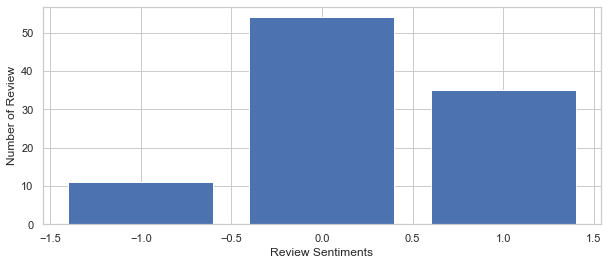

In [46]:
plt.figure(figsize =(10, 4))
Sentiment_count=df_sample.groupby('Sentiment_value').count()
plt.bar(Sentiment_count.index.values, Sentiment_count['Text'])
plt.xlabel('Review Sentiments')
plt.ylabel('Number of Review')
plt.show()

In [47]:
#tokenizer to remove unwanted elements
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
#count vector BoW
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts= cv.fit_transform(df_sample['Text'])
#train and test
X_train, X_test, y_train, y_test = train_test_split(text_counts, df_sample['Sentiment_value'], test_size=0.3, random_state=1)

In [48]:
X_train

<70x832 sparse matrix of type '<class 'numpy.int64'>'
	with 896 stored elements in Compressed Sparse Row format>

In [49]:
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.5


The classification rate of 40.0% using CountVector(or BoW) is not considered as good accuracy.

In [50]:
#term frequency-inverse
tf=TfidfVectorizer()
text_tf= tf.fit_transform(df_sample['Text'])
X_train, X_test, y_train, y_test = train_test_split(text_tf, df_sample['Sentiment_value'], test_size=0.3, random_state=123)

In [51]:
X_train

<70x923 sparse matrix of type '<class 'numpy.float64'>'
	with 1249 stored elements in Compressed Sparse Row format>

In [52]:
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.6


The classification rate of 63.33% using TF-IDF(Term Frequency-Inverse Document Frequency) performed better in accuracy.

#### Another option how to do sentiment analysis is to use library TextBlob.

In [53]:
blob = TextBlob(text)
blob.tags[:10]

[('Natural', 'NNP'),
 ('gas', 'NN'),
 ('prices', 'NNS'),
 ('have', 'VBP'),
 ('surged', 'VBD'),
 ('in', 'IN'),
 ('Europe', 'NNP'),
 ('as', 'IN'),
 ('countries', 'NNS'),
 ('exit', 'VBP')]

In [54]:
nltk.download('brown', quiet=True)
blob.noun_phrases[:10]

WordList(['natural gas prices', 'europe', 'countries exit', 'covid-19', 'impact consumers', 'europe', 'natural gas', 'past spring', 'countries restart', 'east asian countries'])

In [55]:
for sentence in blob.sentences:
    print(sentence.sentiment.polarity)

0.05
-0.08333333333333333
0.0
0.0
0.06999999999999999
-0.0625
0.0
-0.16666666666666666
0.1


TextBlob returns polarity and subjectivity of a sentence. Polarity lies between [-1,1], -1 defines a negative sentiment and 1 defines a positive sentiment. 

In [56]:
for sentence in blob.sentences:
    print(sentence.sentiment.subjectivity)

0.7
0.35555555555555557
0.0
0.0
0.3433333333333334
0.1875
0.03333333333333333
0.06666666666666667
0.4


Subjectivity lies between [0,1]. Subjectivity quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinion rather than factual information.

#### Notes
* Pipelines
    - https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976
    - https://www.analyticsvidhya.com/blog/2020/01/build-your-first-machine-learning-pipeline-using-scikit-learn/
* Parameters tuning
    - https://machinelearningmastery.com/how-to-tune-algorithm-parameters-with-scikit-learn/
* Text analytics
    - https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk
    - https://www.nltk.org
    - https://towardsdatascience.com/basic-binary-sentiment-analysis-using-nltk-c94ba17ae386
    - https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524